## Put a cluster on a substrate

After defining a cluster of our chosen shape and a substrate we like, let us put the two together.
In this rigid world the operation is rather simple: the energy function is evaluated at the position of each particle. 
Summing them up yields the energy, force and torque on the CM.

In [1]:
from matplotlib.colors import Normalize

# Substrate
from tool_create_substrate import calc_matrices_bvect
from tool_create_substrate import particle_en_gaussian, calc_en_gaussian
from tool_create_substrate import substrate_from_params

# Cluster
from tool_create_cluster import rotate, cluster_from_params

# Energy landcape as a function of translation
from static_trasl_map import static_traslmap
# Energy landcape as a function of rotation
from static_roto_map import static_rotomap
# Energy landcape as a function of roto-translation
from static_rototrasl_map import static_rototraslmap

# Misc
from tool_create_substrate import gaussian, get_ks
from misc import get_brillouin_zone_2d, plot_BZ2d, plot_UC, plt_cosmetic

### Define the system 

In [2]:
rho = 1+1/20 # Mismatch (if substrate spacing fixed to 1). Put 1 to test commensurate.
params = {
    # --- SUBSTRATE ---
    'sub_basis': [[0,0]],
    'b1': [1,0],
    'b2': [-1/2, sqrt(3)/2],
    'epsilon': 1,
    'well_shape': 'gaussian',
    'sigma': 0.1, 'a': 0.3, 'b': 0.45,
    # --- CLUSTER ---
    'a1': rho*np.array([1,0]), 'a2': rho*np.array([1/2,-sqrt(3)/2]), # triangular lattice
    'cl_basis': [[0,0]], # no basis
    'cluster_shape': 'circle',
    'N1': 25, 'N2': 25,
    'theta': 0, 'pos_cm': [0, 0] # Start in the "obvious" position, move and rotate later
}

#### Substrate

In [3]:
R = max([np.linalg.norm([b for b in [params['b1'], params['b2']]])])
u, u_inv = calc_matrices_bvect(params['b1'], params['b2'])
S = u_inv.T # Lattice matrix

pen_func, en_func, en_inputs = substrate_from_params(params)

##### Plot to check

Plot the value of substrate energy over a regular grid of points.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


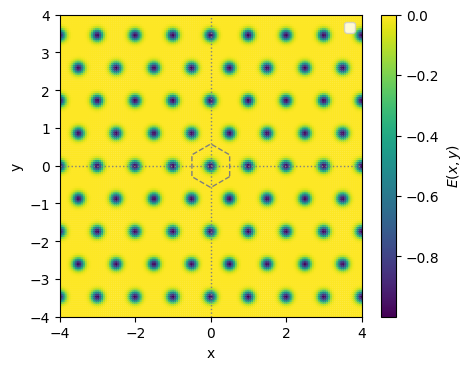

In [4]:
x0, x1, nx = -4, 4, 150
y0, y1, ny = -4, 4, 150
xx, yy = np.meshgrid(np.linspace(x0, x1, nx), np.linspace(y0, y1, ny))
pp = np.stack([xx, yy], axis=2)
p = np.reshape(pp, (pp.shape[0]*pp.shape[1], 2))

en, F, tau = pen_func(p, [0,0], *en_inputs)

fig, axE = plt.subplots(1,1, dpi=100, sharex=True, sharey=True, figsize=(5,4))
# fig.suptitle(title)
plt_params = {'ls': '--', 'color': 'tab:gray', 'lw': 1, 'fill': False}
s0 = 1

# Energy
sc = axE.scatter(p[:,0], p[:,1], c=en, s=s0)
plt.colorbar(sc, label=r'$E(x,y)$', ax=axE)
if params['well_shape'] != 'Sin': plot_BZ2d(axE, get_brillouin_zone_2d(S),plt_params)
#axE.legend(loc='upper right')
axE.set_xlim([x0, x1])
axE.set_ylim([y0, y1])
axE.set_ylabel('y')
axE.set_aspect('equal')
plt_cosmetic(axE)
plt.show()

### Cluster

Now create a cluster that will interact with the substrate above

Cluster circle of size N=571


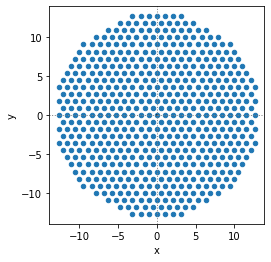

In [5]:
# Create the cluster
pos = cluster_from_params(params)
N = pos.shape[0] # store the number of particles
print("Cluster %s of size N=%i" % (params['cluster_shape'], N))

# It's more convenient to return a cluster in the origin, then shift and rotate outside of the function
pos = rotate(pos, params['theta']) + params['pos_cm']

plt.scatter(pos[:,0], pos[:,1], s=20)
plt.quiver(0,0, *params['pos_cm'], angles='xy', scale_units='xy', scale=1)
plt_cosmetic(plt.gca())
plt.show()

### Snapshots

Move and rotate the cluster at some position and compute the energy/force componentes/torque.
Plot the resulting distribution on the cluster, to appreciate what is going on.

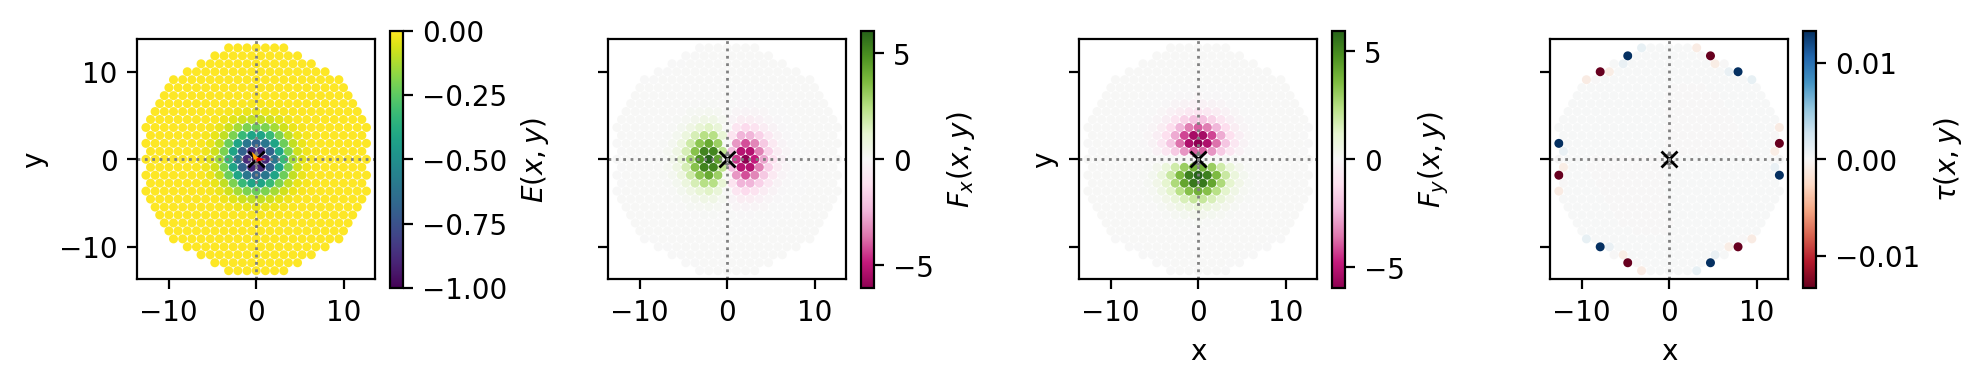

-------------------------------------------------------------------------------- 



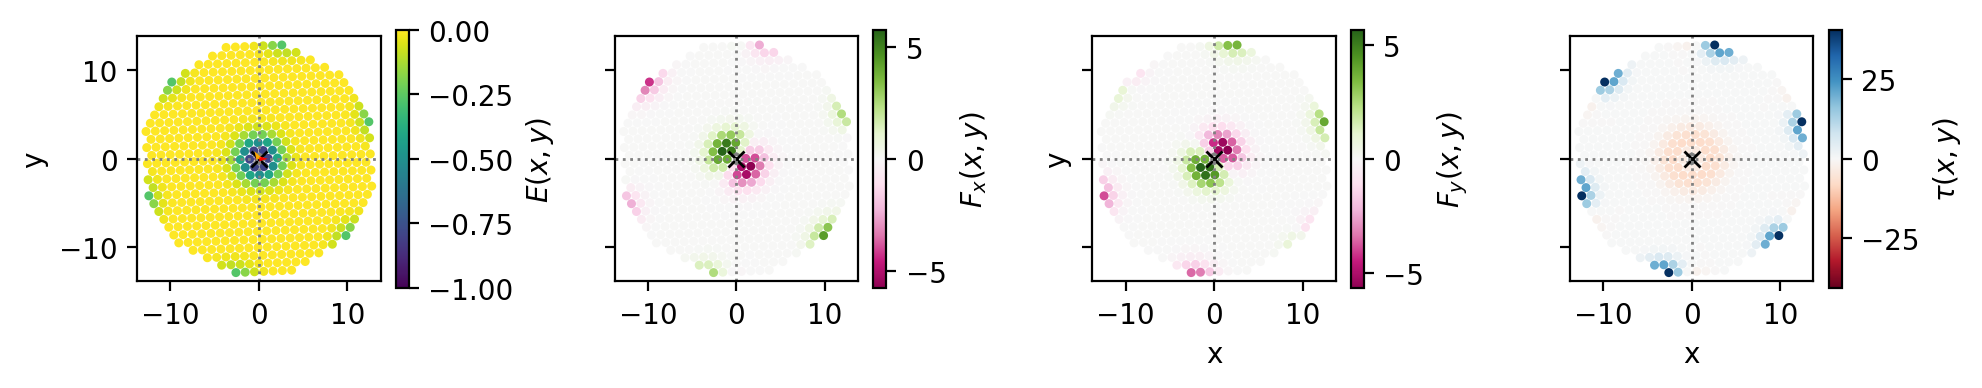

-------------------------------------------------------------------------------- 



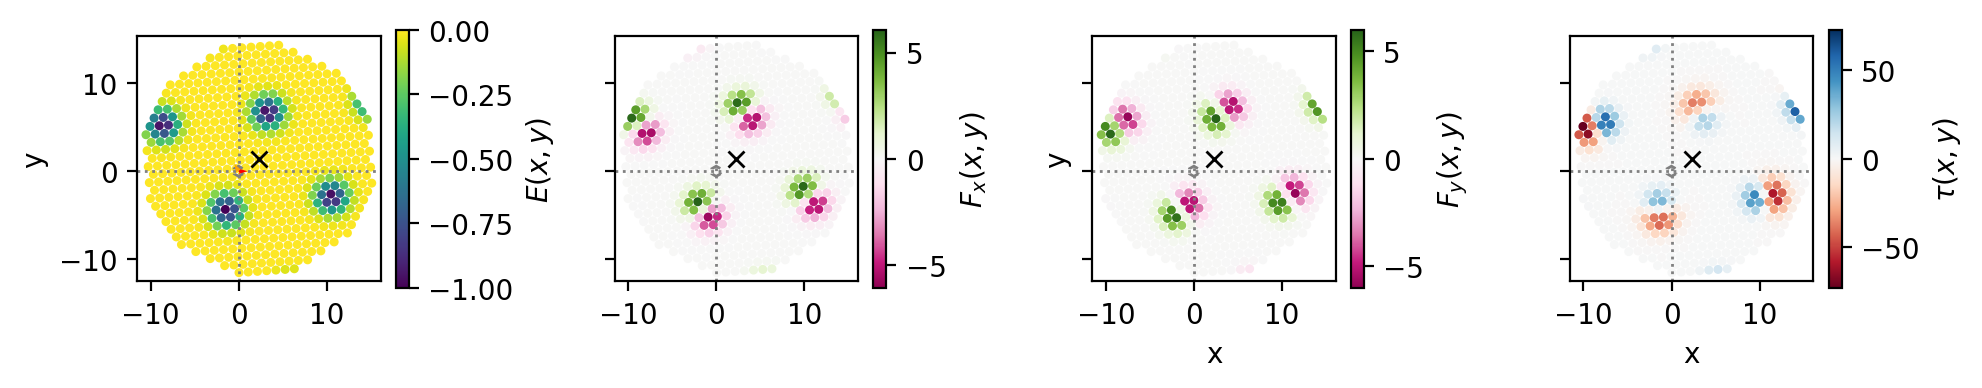

-------------------------------------------------------------------------------- 



In [6]:
for theta, cm in zip([0,      2.5,     4,       ], 
                     [[0,0], [0,0], [2.3,1.4]],
                    ):
    c_pos = rotate(pos.copy(), theta)
    # Energy of cluster 
    en, F, tau = pen_func(c_pos+cm, cm, *en_inputs)

    #fig, ((axE, axFx), (axFy, axtau)) = plt.subplots(2,2, dpi=100, sharex=True, sharey=True, figsize=(6,4))
    fig, (axE, axFx, axFy, axtau) = plt.subplots(1,4, dpi=200, sharex=False, sharey=True, figsize=(10,2))
    plt_params = {'ls': '--', 'color': 'tab:gray', 'lw': 1, 'fill': False}
    s0 = 5 # Size of points
    marker = 'o'
    x0, x1, y0, y1 = np.min((c_pos+cm)[:,0])-1, np.max((c_pos+cm)[:,0])+1, np.min((c_pos+cm)[:,1])-1, np.max((c_pos+cm)[:,1]) +1

    # Energy
    norm = Normalize(-1,0)
    #norm = None
    sc = axE.scatter((c_pos+cm)[:,0], (c_pos+cm)[:,1], c=en, s=s0, marker=marker, norm=norm)
    plt.colorbar(sc, label=r'$E(x,y)$', ax=axE)
    axE.plot(*cm, 'x', color='black', label='$r_\mathrm{cm}$')
    if params['well_shape'] != 'Sin': plot_BZ2d(axE, get_brillouin_zone_2d(S), plt_params)
    axE.quiver(0, 0, *S[0], angles='xy', scale_units='xy', scale=1, zorder=5, color='red', label='b1')
    axE.quiver(0, 0, *S[1], angles='xy', scale_units='xy', scale=1, zorder=5, color='orange', label='b2')
    #axE.legend()
    axE.set_xlim([x0, x1])
    axE.set_ylim([y0, y1])
    plt_cosmetic(axE)
    axE.set_xlabel('')
    #-------------------------

    # Force along x
    side = np.max(np.abs(F[:,0]))
    norm = Normalize(-side, side)
    sc = axFx.scatter((c_pos+cm)[:,0], (c_pos+cm)[:,1], c=F[:,0], s=s0, marker=marker, cmap='PiYG', norm=norm)
    plt.colorbar(sc, label=r'$F_x(x,y)$', ax=axFx)
    axFx.plot(*cm, 'x', color='black', label='$r_\mathrm{cm}$')
    if params['well_shape'] != 'Sin': plot_BZ2d(axFx, get_brillouin_zone_2d(S), plt_params)
    axFx.set_xlim([x0, x1])
    axFx.set_ylim([y0, y1])
    plt_cosmetic(axFx)
    axFx.set_xlabel('')
    axFx.set_ylabel('')
    #-------------------------

    # Force along y
    side = np.max(np.abs(F[:,1]))
    norm = Normalize(-side, side)
    sc = axFy.scatter((c_pos+cm)[:,0], (c_pos+cm)[:,1], c=F[:,1], s=s0, marker=marker, cmap='PiYG', norm=norm)
    plt.colorbar(sc, label=r'$F_y(x,y)$', ax=axFy)
    axFy.plot(*cm, 'x', color='black', label='$r_\mathrm{cm}$')
    if params['well_shape'] != 'Sin': plot_BZ2d(axFy, get_brillouin_zone_2d(S), plt_params)
    axFy.set_xlim([x0, x1])
    axFy.set_ylim([y0, y1])
    plt_cosmetic(axFy)
    #-------------------------

    # Torque
    side = np.max(np.abs(tau))
    norm = Normalize(-side, side)
    sc = axtau.scatter((c_pos+cm)[:,0], (c_pos+cm)[:,1], c=tau, s=s0, marker=marker, cmap='RdBu', norm=norm)
    plt.colorbar(sc, label=r'$\tau(x,y)$', ax=axtau)
    axtau.plot(*cm, 'x', color='black', label='$r_\mathrm{cm}$')
    if params['well_shape'] != 'Sin': plot_BZ2d(axtau, get_brillouin_zone_2d(S), plt_params)
    axtau.set_xlim([x0, x1])
    axtau.set_ylim([y0, y1])
    plt_cosmetic(axtau)
    axtau.set_ylabel('')
    #-------------------------

    plt.tight_layout()
    plt.show()
    print('-'*80, '\n')

### Translational landscape driver

From a single snapshot of the cluster at a given position, we can check the energy landscape on the CM as a function of translations in x, y (at fixed misalignemet).
This involves defining a suitable grid, preferibly coherent with the symmetry, translate the cluster, compute the energy and repeat, while keeping track of this all.

There's a small script that wrap this process: ```static_traslmap```.
It takes as input the start point in terms of the lattice vectors (```da11```, ```da21``` as in start from the point $(x_0, y_0) = d_{a_{1},1} \mathbf{a}_1 + da_{a_{2},1} \mathbf{a}_2$), the end points and how many division along each direciton (```nbin```).
The lattice vectors are given in terms of the $S$ matrix.
The cluster is passed as numpy array of positions.
The substrate energy is computed by passing the wrapper the energy function and its inputs

In [7]:
#pos = c_pos.copy() # in case you ran the roto-trasl part below and want to study better that conf

In [8]:
data = static_traslmap(pos, {"da11": -1.5, "da12": 1.5, 
                             "da21": -1.5, "da22": 1.5,
                             "nbin": 150,
                             'S': S, 'en_params': en_inputs}, 
                       en_func, log_propagate=True)

# Separate the output data into components 
pp = data[:,:2]
enmap = data[:,2]
Fmap = data[:,3:5]
taumap = data[:,5]

#### Plot the four quantities calculated

The folowing cell is just lots of plotting options.
One canvas per quantity.

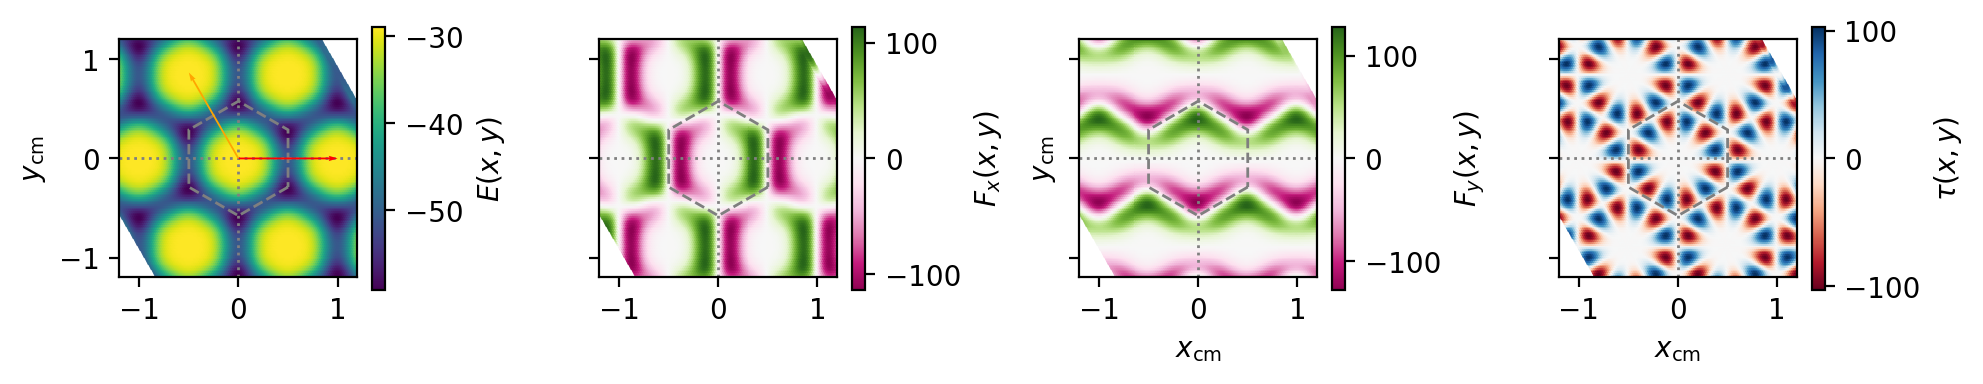

-------------------------------------------------------------------------------- 



In [9]:
#fig, ((axE, axFx), (axFy, axtau)) = plt.subplots(2,2, dpi=300, sharex=True, sharey=True, figsize=(8,6))
fig, (axE, axFx, axFy, axtau) = plt.subplots(1,4, dpi=200, sharex=False, sharey=True, figsize=(10,2))
plt_params = {'ls': '--', 'color': 'tab:gray', 'lw': 1, 'fill': False}
s0 = 0.8 # Size of points
marker = 's'
# Plot limits
x0, x1 = -1.2, 1.2
y0, y1 = -1.2, 1.2

# Energy
# norm = Normalize(-N,0)
norm = None
sc = axE.scatter(pp[:,0], pp[:,1], c=enmap, s=s0, marker=marker, norm=norm)
plt.colorbar(sc, label=r'$E(x,y)$', ax=axE)
if params['well_shape'] != 'Sin': plot_BZ2d(axE, get_brillouin_zone_2d(S), plt_params)
axE.quiver(0, 0, *S[0], angles='xy', scale_units='xy', scale=1, zorder=5, color='red', label=r' b1')
axE.quiver(0, 0, *S[1], angles='xy', scale_units='xy', scale=1, zorder=5, color='orange', label=r' b2')
#axE.legend()
axE.set_xlim([x0, x1])
axE.set_ylim([y0, y1])
plt_cosmetic(axE)
axE.set_ylabel(r'$y_\mathrm{cm}$')
axE.set_xlabel('')
#-------------------------

# Force along x
cside = np.max(np.abs(Fmap[:,0]))
norm = Normalize(-cside, cside)
sc = axFx.scatter(pp[:,0], pp[:,1], c=Fmap[:,0], s=s0, marker=marker, cmap='PiYG', norm=norm)
plt.colorbar(sc, label=r'$F_x(x,y)$', ax=axFx)
if params['well_shape'] != 'Sin': plot_BZ2d(axFx, get_brillouin_zone_2d(S), plt_params)
axFx.set_xlim([x0, x1])
axFx.set_ylim([y0, y1])
plt_cosmetic(axFx)
axFx.set_xlabel('')
axFx.set_ylabel('')
#-------------------------

# Force along y
cside = np.max(np.abs(Fmap[:,1]))
norm = Normalize(-cside, cside)
sc = axFy.scatter(pp[:,0], pp[:,1], c=Fmap[:,1], s=s0, marker=marker, cmap='PiYG', norm=norm)
plt.colorbar(sc, label=r'$F_y(x,y)$', ax=axFy)
if params['well_shape'] != 'Sin': plot_BZ2d(axFy, get_brillouin_zone_2d(S), plt_params)
axFy.set_xlim([x0, x1])
axFy.set_ylim([y0, y1])
plt_cosmetic(axFy)
axFy.set_xlabel(r'$x_\mathrm{cm}$')
axFy.set_ylabel(r'$y_\mathrm{cm}$')
#-------------------------

# Torque
cside = np.max(np.abs(taumap))
norm = Normalize(-cside, cside)
sc = axtau.scatter(pp[:,0], pp[:,1], c=taumap, s=s0, marker=marker, cmap='RdBu', norm=norm)
plt.colorbar(sc, label=r'$\tau(x,y)$', ax=axtau)
if params['well_shape'] != 'Sin': plot_BZ2d(axtau, get_brillouin_zone_2d(S), plt_params)
axtau.set_xlim([x0, x1])
axtau.set_ylim([y0, y1])
plt_cosmetic(axtau)
axtau.set_xlabel(r'$x_\mathrm{cm}$')
axtau.set_ylabel('')
#-------------------------

plt.tight_layout()
plt.show()
print('-'*80, '\n')

### Rotational landscape driver

The other degree of freedom we can play with aside translation is rotation.
So there's another wrapper function that let's you explore the rotational energy landscape at fixed CM translation.

It expects similar input: position, energy function and specifications of what to explore, i.e. a starting angle, a finish one, and a number of pointsin between.

In [10]:
data = static_rotomap(pos, {"theta0": -30, "theta1": 30, "ntheta": 1000, 'en_params': en_inputs}, en_func, 
                      log_propagate=True)

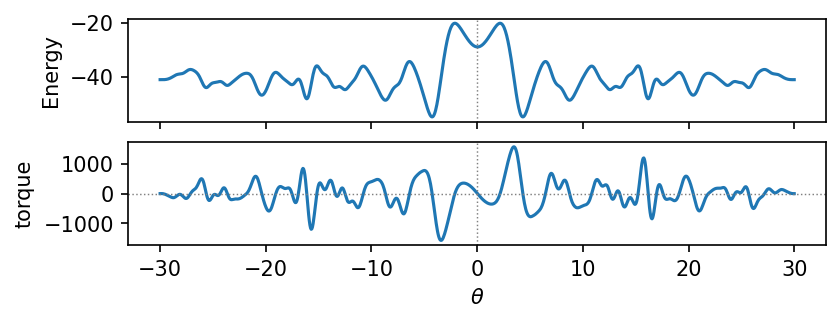

In [11]:
fig, (axE, axtau) = plt.subplots(2,1, dpi=150, sharex=True, figsize=(6,2))
axE.plot(data[:,0], data[:,1])
axE.axvline(ls=':', color='gray', lw=0.7)

axtau.plot(data[:,0], data[:,4])
axtau.axhline(ls=':', color='gray', lw=0.7)
axtau.axvline(ls=':', color='gray', lw=0.7)

axE.set_ylabel('Energy')
axtau.set_ylabel('torque')
axtau.set_xlabel(r'$\theta$')

axtau.set_aspect('auto')
axE.set_aspect('auto')

### Roto-trasl map
We can go one step forward and compute shift yielding the energy minimum for any rotation!

This might be a bit slow (4min on a single core on my laptop for N=500 particles, 80x80x100 points).
The grid is not too fine, so you might get some residual rotque and force. If we are close to the real minimum, these should be considerably smaller than the scale above.

In [12]:
data = static_rototraslmap(pos, {"da11": 0, "da12": 1, 
                                 "da21": 0, "da22": 1,
                                 "nbin": 80,
                                 "theta0": -30, "theta1": 30, "ntheta": 100,
                                 'S': S, 'en_params': en_inputs}, 
                           en_func, log_propagate=False, debug=True)
dmin = data[np.argmin(data[:,3])]
print("Cluster size N=%i Minimum energy E=%.4g at theta=%.5g x,y=%.5g, %.5g. Torque=%.5g Fx=%.5g Fy=%.5g" % (
    N, *dmin[[3,0,1,2,6,4,5]])
     )
thmin, xmin, ymin = dmin[[0,1,2]]

Cluster size N=571 Minimum energy E=-60.27 at theta=0.90909 x,y=0, 0.581. Torque=8.0475 Fx=-0.0004854 Fy=-3.9148


#### Visualise
Let's take a look at this minimum energy configuration, shall we?

571 -60.24721286109571


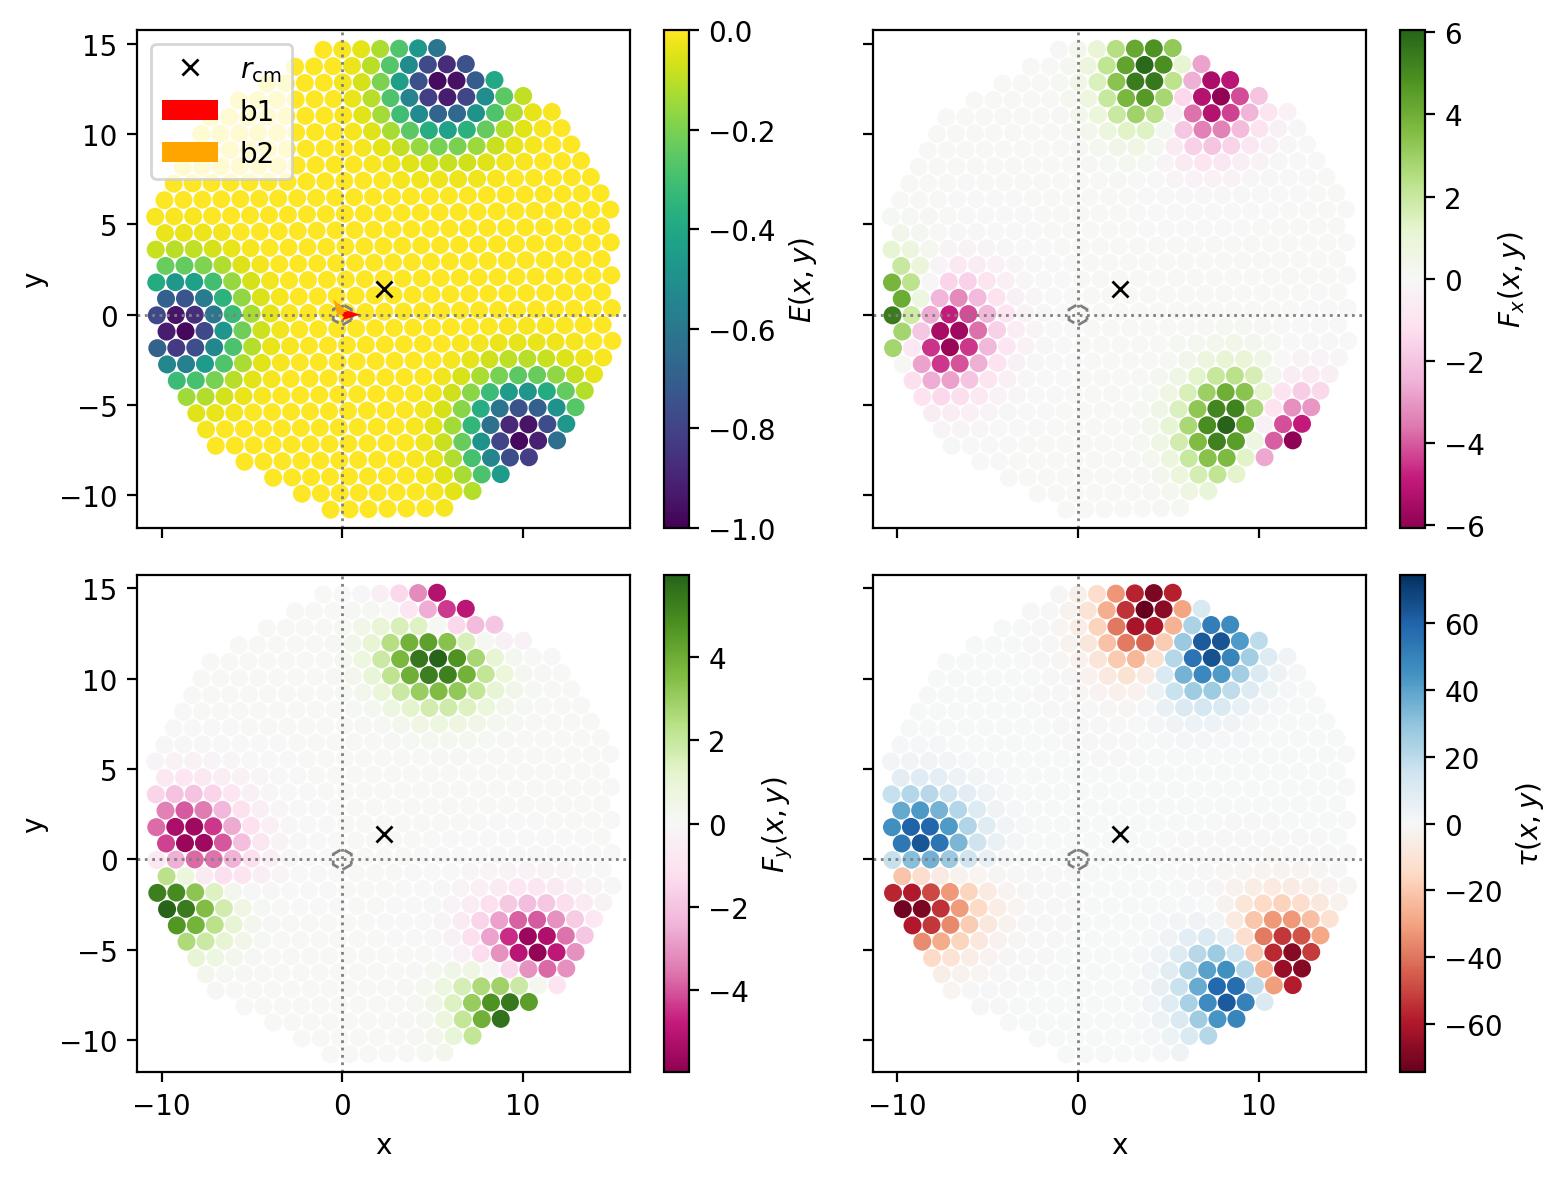

-------------------------------------------------------------------------------- 



In [13]:
c_pos = rotate(pos.copy(), thmin) + [xmin,ymin]
# Energy of cluster 
en, F, tau = pen_func(c_pos+[xmin,ymin], [xmin,ymin], *en_inputs)

print(N, sum(en))
fig, ((axE, axFx), (axFy, axtau)) = plt.subplots(2,2, dpi=200, sharex=True, sharey=True, figsize=(8,6))
plt_params = {'ls': '--', 'color': 'tab:gray', 'lw': 1, 'fill': False}
s0 = 30 # Size of points
marker = 'o'
x0, x1, y0, y1 = np.min((c_pos+cm)[:,0])-1, np.max((c_pos+cm)[:,0])+1, np.min((c_pos+cm)[:,1])-1, np.max((c_pos+cm)[:,1]) +1

# Energy
norm = Normalize(-1,0)
#norm = None
sc = axE.scatter((c_pos+cm)[:,0], (c_pos+cm)[:,1], c=en, s=s0, marker=marker, norm=norm)
plt.colorbar(sc, label=r'$E(x,y)$', ax=axE)
axE.plot(*cm, 'x', color='black', label='$r_\mathrm{cm}$')
if params['well_shape'] != 'Sin': plot_BZ2d(axE, get_brillouin_zone_2d(S), plt_params)
axE.quiver(0, 0, *S[0], angles='xy', scale_units='xy', scale=1, zorder=5, color='red', label='b1')
axE.quiver(0, 0, *S[1], angles='xy', scale_units='xy', scale=1, zorder=5, color='orange', label='b2')
axE.legend()
axE.set_xlim([x0, x1])
axE.set_ylim([y0, y1])
plt_cosmetic(axE)
axE.set_xlabel('')
#-------------------------

# Force along x
side = np.max(np.abs(F[:,0]))
norm = Normalize(-side, side)
sc = axFx.scatter((c_pos+cm)[:,0], (c_pos+cm)[:,1], c=F[:,0], s=s0, marker=marker, cmap='PiYG', norm=norm)
plt.colorbar(sc, label=r'$F_x(x,y)$', ax=axFx)
axFx.plot(*cm, 'x', color='black', label='$r_\mathrm{cm}$')
if params['well_shape'] != 'Sin': plot_BZ2d(axFx, get_brillouin_zone_2d(S), plt_params)
axFx.set_xlim([x0, x1])
axFx.set_ylim([y0, y1])
plt_cosmetic(axFx)
axFx.set_xlabel('')
axFx.set_ylabel('')
#-------------------------

# Force along y
side = np.max(np.abs(F[:,1]))
norm = Normalize(-side, side)
sc = axFy.scatter((c_pos+cm)[:,0], (c_pos+cm)[:,1], c=F[:,1], s=s0, marker=marker, cmap='PiYG', norm=norm)
plt.colorbar(sc, label=r'$F_y(x,y)$', ax=axFy)
axFy.plot(*cm, 'x', color='black', label='$r_\mathrm{cm}$')
if params['well_shape'] != 'Sin': plot_BZ2d(axFy, get_brillouin_zone_2d(S), plt_params)
axFy.set_xlim([x0, x1])
axFy.set_ylim([y0, y1])
plt_cosmetic(axFy)
#-------------------------

# Torque
side = np.max(np.abs(tau))
norm = Normalize(-side, side)
sc = axtau.scatter((c_pos+cm)[:,0], (c_pos+cm)[:,1], c=tau, s=s0, marker=marker, cmap='RdBu', norm=norm)
plt.colorbar(sc, label=r'$\tau(x,y)$', ax=axtau)
axtau.plot(*cm, 'x', color='black', label='$r_\mathrm{cm}$')
if params['well_shape'] != 'Sin': plot_BZ2d(axtau, get_brillouin_zone_2d(S), plt_params)
axtau.set_xlim([x0, x1])
axtau.set_ylim([y0, y1])
plt_cosmetic(axtau)
axtau.set_ylabel('')
#-------------------------

plt.tight_layout()
plt.show()
print('-'*80, '\n')

Does this make sense as a minimum-energy configuration?